# Fantasy Baseball Statistical Analysis

This is a linear regression analysis of fantasy baseball year over year performance. The goal is to create and predict a season fantasy score that equally weights the 5 fantasy baseball hitting categories: Hits, Runs, RBIs, Home Runs, and Stolen Bases. A players ranking for each individual category is a number 0-1 corresponding with their percentile ranking for that season in that category. A predictive model, using linear regression, then attempts to predict a players future season fantasy ranking using certain variables from the pioir season.

### data source
Data for historic baseball seasons was gathered from Sean Lahaman's baseball database, http://www.seanlahman.com/.

In [1]:
import pandas as pd
data = pd.read_csv("~/Documents/Data/fb_regression_project/baseballdatabank-master/core/Batting.csv")
print(data.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')


Adding some supplemental data points needed for our analysis:

In [2]:
    # batting average 
    data['BA'] = pd.Series((data.H/data.AB)*1000, index=data.index)
    # last year
    data['last_year'] = data.yearID - 1
    # slugging percentage
    data["SLG"] = (data['HR']*3.0 + data['3B']*3.0 + data['2B']*2.0 + data['3B']*3.0 + (data['H'] - (data['HR'] - data['3B'] - data['2B'])))/data['AB']
    # on base percentage
    data["OBP"] = (data.H + data.BB + data.HBP)/(data.AB + data.BB + data.SF + data.HBP)
    # on base plus slugging
    data["OPS"] = data.SLG + data.OBP

Let's preview the first 5 rows of our fantasy relevant data:

In [3]:
key_data = ['playerID','BA', 'R', 'HR', 'RBI', 'SB']
print(data[key_data].head(10))

    playerID          BA   R  HR   RBI    SB
0  abercda01    0.000000   0   0   0.0   0.0
1   addybo01  271.186441  30   0  13.0   8.0
2  allisar01  291.970803  28   0  19.0   3.0
3  allisdo01  330.827068  28   2  27.0   1.0
4  ansonca01  325.000000  29   0  16.0   6.0
5  armstbo01  224.489796   9   0   5.0   0.0
6  barkeal01  250.000000   0   0   2.0   0.0
7  barnero01  401.273885  66   0  34.0  11.0
8  barrebi01  200.000000   1   0   1.0   0.0
9  barrofr01  151.162791  13   0  11.0   1.0


Every fantasy data point will be ranked on a percentile scale. Batting average (BA) will need to be limited to batters with some number of At Bats (AB). It would be possible for a batter to have 1 AB with a 1000 batting average, which would be misleading.
Let's examine AB plotted with BA:

In [4]:
print(data.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'BA', 'last_year', 'SLG', 'OBP', 'OPS'],
      dtype='object')


In [5]:
data.plot.scatter('BA', 'AB', 1)

Examing the graph, we should limit data to batters with at least 100 ABs. We will also limit to 2010 and on. The dataset goes back to the 1800's, and the game has changed quite a bit since then.

In [6]:
data = data[(data.AB >= 100) & (data.yearID >= 2010)]

To quantify overall performance, we will calculate a fantasy_score that equally weights all five batting metrics. Since fantasy baseball scoring is based on winning each category, this equal weighting makes sense.

In [7]:
# create percentile ranking by year for each metric
data['BA_rank'] = data.groupby(data.yearID)['BA'].rank(pct=True)
data['R_rank'] = data.groupby("yearID")['R'].rank(pct=True)
data['HR_rank'] = data.groupby("yearID")['HR'].rank(pct=True)
data['RBI_rank'] = data.groupby("yearID")['RBI'].rank(pct=True)
data['SB_rank'] = data.groupby("yearID")['SB'].rank(pct=True)
data['fantasy_score'] = pd.Series(0.2 * data.BA_rank + 0.2 * data.R_rank + 0.2 * data.HR_rank + 0.2 * data.RBI_rank + 0.2 * data.SB_rank, index=data.index)


Now we will join the dataset with itself, using our last_year variable we created.

In [8]:
data = pd.merge(data, data, left_on = ['playerID','yearID'], right_on = ['playerID','last_year'])

print(data.columns)
print(data.head(10))


Index(['playerID', 'yearID_x', 'stint_x', 'teamID_x', 'lgID_x', 'G_x', 'AB_x',
       'R_x', 'H_x', '2B_x', '3B_x', 'HR_x', 'RBI_x', 'SB_x', 'CS_x', 'BB_x',
       'SO_x', 'IBB_x', 'HBP_x', 'SH_x', 'SF_x', 'GIDP_x', 'BA_x',
       'last_year_x', 'SLG_x', 'OBP_x', 'OPS_x', 'BA_rank_x', 'R_rank_x',
       'HR_rank_x', 'RBI_rank_x', 'SB_rank_x', 'fantasy_score_x', 'yearID_y',
       'stint_y', 'teamID_y', 'lgID_y', 'G_y', 'AB_y', 'R_y', 'H_y', '2B_y',
       '3B_y', 'HR_y', 'RBI_y', 'SB_y', 'CS_y', 'BB_y', 'SO_y', 'IBB_y',
       'HBP_y', 'SH_y', 'SF_y', 'GIDP_y', 'BA_y', 'last_year_y', 'SLG_y',
       'OBP_y', 'OPS_y', 'BA_rank_y', 'R_rank_y', 'HR_rank_y', 'RBI_rank_y',
       'SB_rank_y', 'fantasy_score_y'],
      dtype='object')
    playerID  yearID_x  stint_x teamID_x lgID_x  G_x  AB_x  R_x  H_x  2B_x  \
0  abreubo01      2010        1      LAA     AL  154   573   88  146    41   
1  alvarpe01      2010        1      PIT     NL   95   347   42   89    21   
2  andruel01      2010     

Now we need to determine which variables will be good candidates for our predictive model. We will now attempt to identify strong correlations between a prior years individual metric performance, and the following year's fantasy_score. Below we examine the scatter plot for prior year hitting and following year fantasy score.

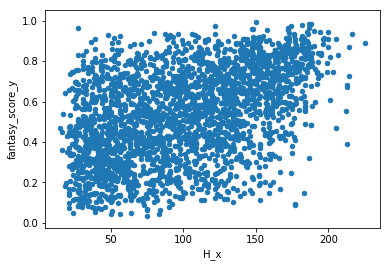

In [9]:
data.plot.scatter('H_x','fantasy_score_y')

Instead of plotting every variable at our disposal, we will define a function "corr_check" that describes the r and p values.

In [10]:
from scipy.stats.stats import pearsonr

def corr_check(x, y):
    corr_vals = pearsonr(x, y)
    if abs(corr_vals[0]) >= 0.8:
        corr_rank = 'very Strong'
    elif abs(corr_vals[0]) >= 0.6:
        corr_rank = 'strong'
    elif abs(corr_vals[0]) >= 0.4:
        corr_rank = 'moderate'
    elif abs(corr_vals[0]) >= 0.2:
        corr_rank = 'weak'
    else:
        corr_rank = 'very Weak'
    if corr_vals[1] < 0.05:
        p_rank = 'strong evidence'
    else:
        p_rank = 'weak evidence'   
    print("r:", corr_vals[0], "is a", corr_rank, 'correlation.')
    print("p:", corr_vals[1], "indicates", p_rank, 'to reject the null hypothesis.')


for col in data.columns:
    try:
        corr_check(data.fantasy_score_y, data[col])
        print('... ',col)
    except:
        pass

r: 0.0075967033054355725 is a very Weak correlation.
p: 0.7029103066849749 indicates weak evidence to reject the null hypothesis.
...  yearID_x
r: -0.02736166883736553 is a very Weak correlation.
p: 0.16946081824082707 indicates weak evidence to reject the null hypothesis.
...  stint_x
r: 0.32263634340267877 is a weak correlation.
p: 3.2931530153327738e-62 indicates strong evidence to reject the null hypothesis.
...  G_x
r: 0.4163656977381193 is a moderate correlation.
p: 2.279819350264612e-106 indicates strong evidence to reject the null hypothesis.
...  AB_x
r: 0.4837993651804385 is a moderate correlation.
p: 3.483869362449192e-148 indicates strong evidence to reject the null hypothesis.
...  R_x
r: 0.4504291950204716 is a moderate correlation.
p: 2.588244532267632e-126 indicates strong evidence to reject the null hypothesis.
...  H_x
r: 0.4093105162131655 is a moderate correlation.
p: 1.6198075059622156e-102 indicates strong evidence to reject the null hypothesis.
...  2B_x
r: 0.230

In [13]:
import statsmodels.api as sm

y = data.fantasy_score_y
X = data[['R_x', 'RBI_x', 'fantasy_score_x', 'OBP_x', 'OPS_x', 'SLG_x', 'BA_rank_x', 'BA_x']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        fantasy_score_y   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     130.1
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          1.15e-163
Time:                        22:09:13   Log-Likelihood:                 642.51
No. Observations:                2523   AIC:                            -1269.
Df Residuals:                    2515   BIC:                            -1222.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2507      0.101     

We will use Runs, Slugging Percentage, and fantasy_score to predict the next years fantasy score by using linear regression.

In [14]:
y = data.fantasy_score_y
X = data[['R_x', 'fantasy_score_x', 'SLG_x']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        fantasy_score_y   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     302.0
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          1.78e-167
Time:                        22:09:15   Log-Likelihood:                 640.36
No. Observations:                2523   AIC:                            -1273.
Df Residuals:                    2519   BIC:                            -1249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1769      0.023     

So our predictive model shows:

y = 0.1769 + (0.0012 * Runs) + (0.3485 * prior year fantasy score) + (0.1994 * Slugging Percentage)

Where y is the following season's fantasy score based on percentile rankings of each category.

Let's bring in 2018 data to determine our fantasy score leaders.

In [18]:
data18 = pd.read_excel("~/Documents/Data/fb_regression_project/batting2018.xlsx")
data18 = data18[data18['AB'] >= 100]
print(data18.columns)
print(data18.head(20))

Index(['Rk', 'Name', 'Age', 'Tm', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+',
       'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'Pos Summary'],
      dtype='object')
        Rk                          Name   Age   Tm  Lg    G   PA   AB    R  \
0    791.0   Francisco Lindor#\lindofr01  24.0  CLE  AL  158  745  661  129   
1    128.0        Mookie Betts\bettsmo01  25.0  BOS  AL  136  614  520  129   
2   1523.0   Christian Yelich*\yelicch01  26.0  MIL  NL  147  651  574  118   
3    863.0       J.D. Martinez\martijd02  30.0  BOS  AL  150  649  569  111   
4   1124.0       Jose Ramirez#\ramirjo01  25.0  CLE  AL  157  698  578  110   
5    168.0        Alex Bregman\bregmal01  24.0  HOU  AL  157  705  594  105   
6    136.0   Charlie Blackmon*\blackch02  31.0  COL  NL  156  696  626  119   
7    214.0     Matt Carpenter*\carpema01  32.0  STL  NL  156  677  564  111   
8     57.0       Nolan Arenado\arenano01  27.0 

Add in our percentile ranking system:

In [72]:
data18["fs_predict"] = 0.1769 + (0.0012 * data18.R) + (0.3485 * data18.fantasy_score) + (0.1994 * data18.SLG)

print(data18.sort_values(by = "fs_predict", ascending = False).head(10))

         Rk                         Name   Age   Tm  Lg    G   PA   AB    R  \
1     128.0       Mookie Betts\bettsmo01  25.0  BOS  AL  136  614  520  129   
2    1523.0  Christian Yelich*\yelicch01  26.0  MIL  NL  147  651  574  118   
3     863.0      J.D. Martinez\martijd02  30.0  BOS  AL  150  649  569  111   
0     791.0  Francisco Lindor#\lindofr01  24.0  CLE  AL  158  745  661  129   
19   1396.0         Mike Trout\troutmi01  26.0  LAA  AL  140  608  471  101   
4    1124.0      Jose Ramirez#\ramirjo01  25.0  CLE  AL  157  698  578  110   
6     136.0  Charlie Blackmon*\blackch02  31.0  COL  NL  156  696  626  119   
9      76.0         Javier Baez\baezja01  25.0  CHC  NL  160  645  606  101   
5     168.0       Alex Bregman\bregmal01  24.0  HOU  AL  157  705  594  105   
769  1191.0        Enny Romero\romeren01  27.0  TOT  NL    4    1    1    1   

       H     ...      SF  IBB  Pos Summary   BA_rank    R_rank   HR_rank  \
1    180     ...       5    8       *98/D4  0.972532  

In [19]:
# lets create our score for this new dataset:
# create percentile ranking by year for each metric
data18['BA_rank'] = data18['BA'].rank(pct=True)
data18['R_rank'] = data18['R'].rank(pct=True)
data18['HR_rank'] = data18['HR'].rank(pct=True)
data18['RBI_rank'] = data18['RBI'].rank(pct=True)
data18['SB_rank'] = data18['SB'].rank(pct=True)
data18['fantasy_score'] = pd.Series(0.2 * data18.BA_rank + 0.2 * data18.R_rank + 0.2 * data18.HR_rank + 0.2 * data18.RBI_rank + 0.2 * data18.SB_rank, index=data18.index)

print(data18.fantasy_score.head(10))

0    0.944890
1    0.968337
2    0.982766
3    0.940681
4    0.941283
5    0.924649
6    0.910621
7    0.822044
8    0.866533
9    0.954509
Name: fantasy_score, dtype: float64
